# Reinforcement Learning – Exercise 1
### Building the Simulation Environment
This notebook implements the required components of the 100-state gridworld environment:
- 1.a: Create the 100-state environment
- 1.b: Define the possible actions
- 1.c: Implement the state transition function
- 1.d: Implement the reward function
- 1.e: Implement a function to perform a single action
- 1.f: Simulate and plot 30 episodes


In [153]:
# ==== ALL IMPORTS IN FIRST CELL ====
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

## 1.a — Create the State Environment

The environment is a 10×10 grid with 100 states, indexed from 0 to 99:

- State 0 → top-left
- State 99 → bottom-right
- State 9 → top-right
- State 90 → bottom-left

We represent each state as an integer, and convert between:
- **state index** (0–99)
- **grid coordinates (row, col)**

In [154]:
# Environment parameters
GRID_SIZE = 10
N_STATES = GRID_SIZE * GRID_SIZE

def state_to_pos(s):
    """Convert state index (0–99) to grid coordinates (row, col)."""
    return divmod(s, GRID_SIZE)

def pos_to_state(r, c):
    """Convert grid coordinates (row, col) to state index."""
    return r * GRID_SIZE + c

# Quick test
print("State 0:", state_to_pos(0))
print("State 99:", state_to_pos(99))
print("Row 3, Col 7 →", pos_to_state(3, 7))

State 0: (0, 0)
State 99: (9, 9)
Row 3, Col 7 → 37


## 1.b — Define the Possible Actions

Each state has up to 4 possible actions:

- `'N'`: move north (row – 1)
- `'S'`: move south (row + 1)
- `'E'`: move east  (col + 1)
- `'W'`: move west  (col – 1)

If an action would move off the grid (e.g., going North from row 0), the agent stays in the same state.

In [155]:
# Action set
ACTIONS = ["N", "S", "E", "W"]

## 1.c — Implement the State Transition Function

The function must:

1. Receive current state `s` and action `a`
2. Convert `s` into grid coordinates
3. Apply the movement (if valid)
4. Return the next state

Invalid moves → remain in same state.

In [156]:
def transition(s, a):
    """Return next state given action, with border checks."""
    r, c = state_to_pos(s)

    if a == "N" and r > 0:
        r -= 1
    elif a == "S" and r < GRID_SIZE - 1:
        r += 1
    elif a == "E" and c < GRID_SIZE - 1:
        c += 1
    elif a == "W" and c > 0:
        c -= 1

    return pos_to_state(r, c)

# Tests
print(transition(0, "N"))  # stays 0
print(transition(0, "E"))  # moves to 1
print(transition(9, "S"))  # stays 9
print(transition(55, "N")) # moves to 45


0
1
19
45


## 1.d — Reward Function

The environment rewards:

- **+1** if the agent reaches goal state (state 99)
- **-1** if the agent hits a terminal hole (state 90)
- **0** otherwise

We assume:
- State 99 = GOAL
- State 90 = BAD STATE


In [157]:
GOAL = 99
BAD = 90

def reward(s):
    """Return reward for entering state s."""
    if s == GOAL:
        return 1
    elif s == BAD:
        return -1
    else:
        return 0

## 1.e — Function to Perform a Single Action

This function:
- takes current state `s`
- picks an action (random for now)
- computes next state using `transition()`
- computes reward using `reward()`
- returns `(next_state, reward)`

In [158]:
def step(s):
    """Take a random action from this state."""
    a = random.choice(ACTIONS)
    next_s = transition(s, a)
    r = reward(next_s)
    return next_s, r

# Episode Path Visualization

We simulate **1 episode**, track all visited states, and visualize the path on a 10×10 grid.

- Each state the agent visits is marked.
- The **start** and **end** are highlighted differently.
- This helps understand the agent's movement during random policy execution.


In [159]:
def run_episode_path(max_steps=50):
    s = 0
    path = [s]

    for _ in range(max_steps):
        s, r = step(s)
        path.append(s)
        if s in [GOAL, BAD]:
            break
    return path

path = run_episode_path()
path[:20], len(path)


([0, 10, 20, 21, 20, 20, 10, 11, 12, 22, 23, 13, 3, 2, 12, 13, 3, 13, 14, 4],
 51)

## 1.f — Simulate Episodes and Collect Statistics

We simulate:

- 30 episodes
- Each episode starts at state 0
- Ends when:
  - state == GOAL, or
  - state == BAD, or
  - max 50 steps reached

For each episode record:
- total reward
- total number of steps

We finish by plotting:
- A boxplot of total rewards
- A boxplot of total steps


In [160]:
rewards = []
steps_list = []
visit_counts = np.zeros((GRID_SIZE, GRID_SIZE))  # reset counts

def run_episode(max_steps=50):
    s = 0
    total_reward = 0

    for step_i in range(max_steps):
        s, rwd = step(s)
        total_reward += rwd

        r, c = state_to_pos(s)
        visit_counts[r, c] += 1

        if s in [GOAL, BAD]:
            return total_reward, step_i + 1

    return total_reward, max_steps  # ended by timeout

# Run 30 episodes
for _ in range(10000):
    r, st = run_episode()
    rewards.append(r)
    steps_list.append(st)

rewards = np.array(rewards)
steps_list = np.array(steps_list)


## Boxplots of Total Rewards and Total Steps
These boxplots summarize how the agent performed across 30 random-policy episodes.
Box Plot

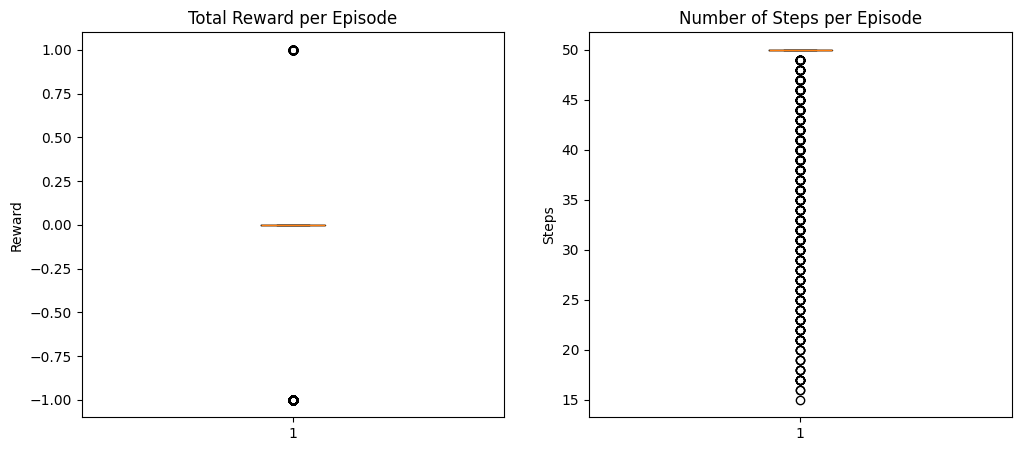

Mean Reward: -0.0382
Mean Steps: 49.3677


In [161]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.boxplot(rewards)
plt.title("Total Reward per Episode")
plt.ylabel("Reward")

plt.subplot(1,2,2)
plt.boxplot(steps_list)
plt.title("Number of Steps per Episode")
plt.ylabel("Steps")

plt.show()

print("Mean Reward:", rewards.mean())
print("Mean Steps:", steps_list.mean())


## Heatmap of State Visit Frequency

After running multiple episodes, we can visualize how often each grid state was visited.
This helps us understand the behavior of the agent under a random policy.

- Darker color → fewer visits
- Brighter color → more visits


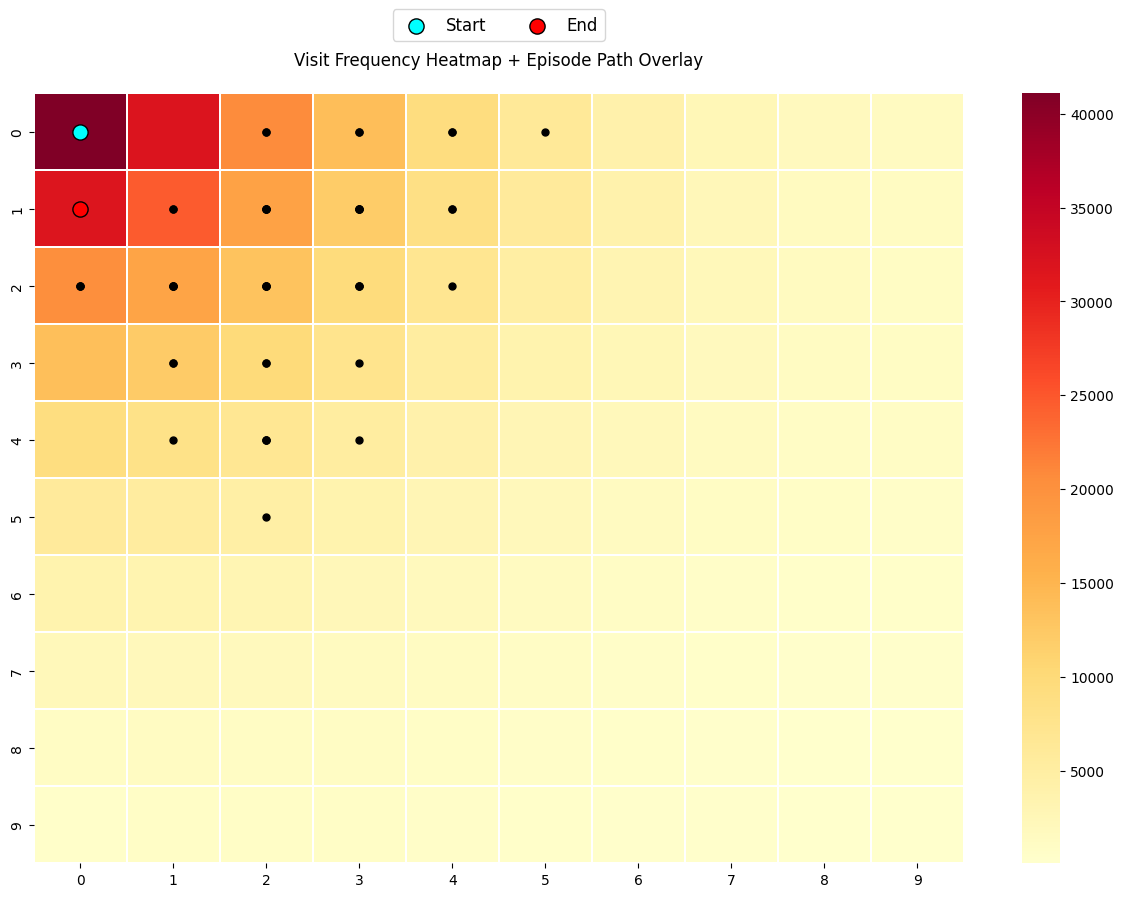

In [162]:
plt.figure(figsize=(15, 10))

# Background heatmap
sns.heatmap(visit_counts, cmap="YlOrRd", linewidths=0.3)

# Overlay episode path
for s in path:
    r, c = state_to_pos(s)
    plt.scatter(c + 0.5, r + 0.5, color="black", s=25)

# Mark START
sr, sc = state_to_pos(path[0])
plt.scatter(sc + 0.5, sr + 0.5, color="cyan", s=120, edgecolors="black", label="Start")

# Mark END (Goal or Bad)
er, ec = state_to_pos(path[-1])
plt.scatter(ec + 0.5, er + 0.5, color="red", s=120, edgecolors="black", label="End")

# Title
plt.title("Visit Frequency Heatmap + Episode Path Overlay", pad=20)

# Legend outside plot, below title
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.12),  # move legend above the plot
    ncol=2,
    frameon=True,
    fontsize=12
)

plt.show()